# Plotting Circle

In [100]:
import os, sys

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
import seaborn as sns

#Own files
from VAE.Surface3D import VAE_3D
from torchgeometry.deep_geometry import rm_generative_models

## Loading MNIST

In [101]:
df = pd.read_csv('../../Data/circle/circle.csv', index_col=0)
DATA = torch.Tensor(df.values).to('cpu') #DATA = torch.Tensor(df.values)
DATA = torch.transpose(DATA, 0, 1)
device = 'cpu'
dataset = DATA

## Loading Model

In [102]:
lr = 0.0002
model = VAE_3D(fc_h = [3, 100],
                 fc_g = [2, 100, 3],
                 fc_mu = [100, 2],
                 fc_var = [100, 2],
                 fc_h_act = [nn.ELU],
                 fc_g_act = [nn.ELU, nn.Identity],
                 fc_mu_act = [nn.Identity],
                 fc_var_act = [nn.Sigmoid]).to(device) #Model used

checkpoint = torch.load('models/circle/vae_circle_3.pt', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
elbo = checkpoint['ELBO']
rec_loss = checkpoint['rec_loss']
kld_loss = checkpoint['KLD']

model.eval()

M = rm_generative_models(model_encoder = model.h,
                        model_decoder = model.g)

## Plotting Learned Model

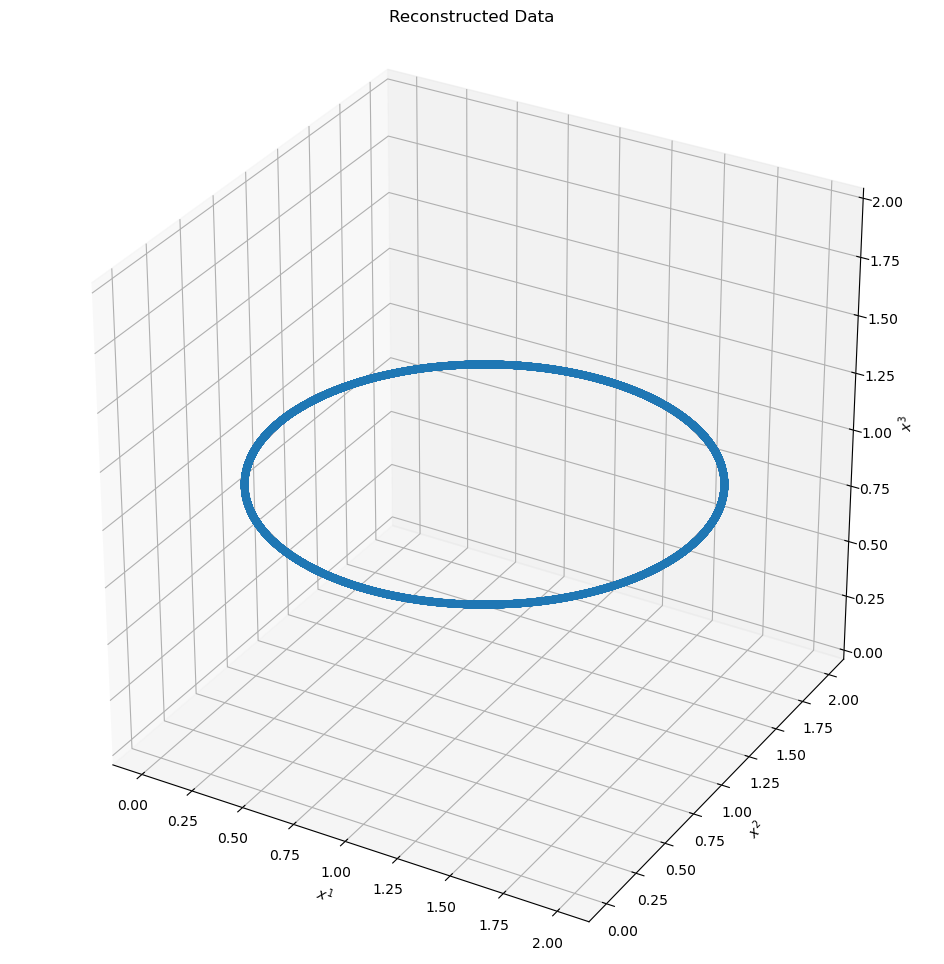

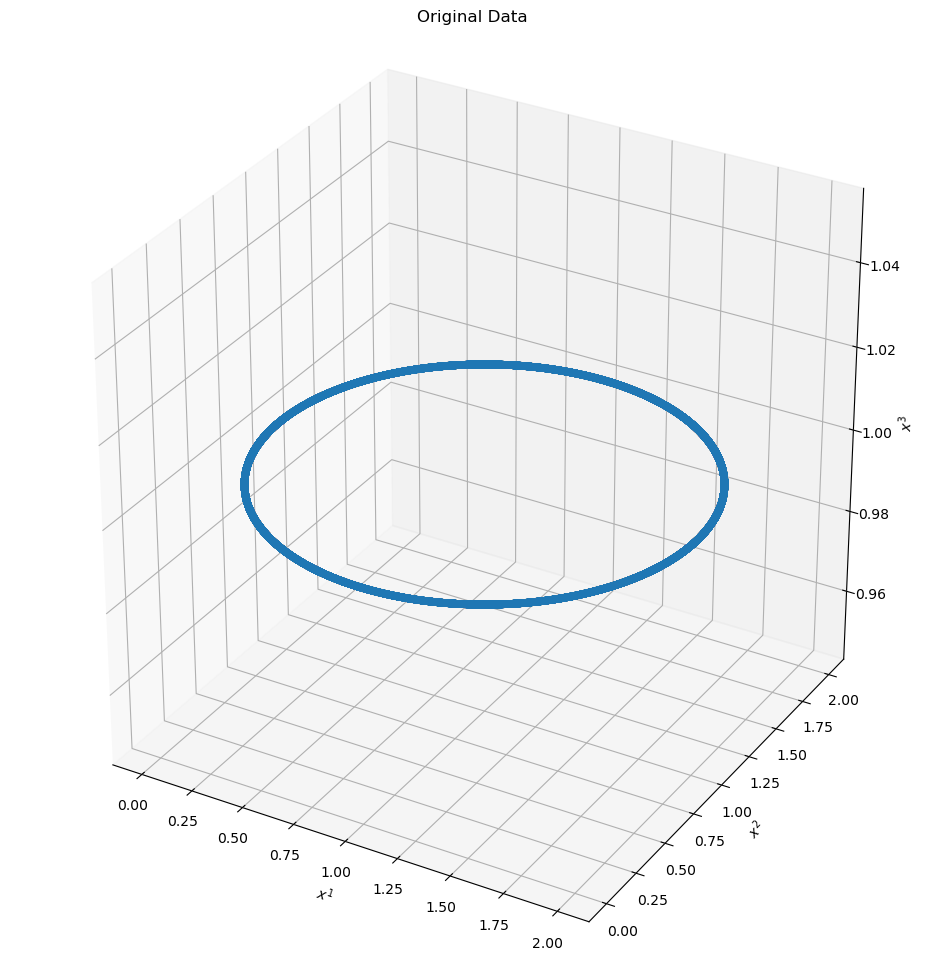

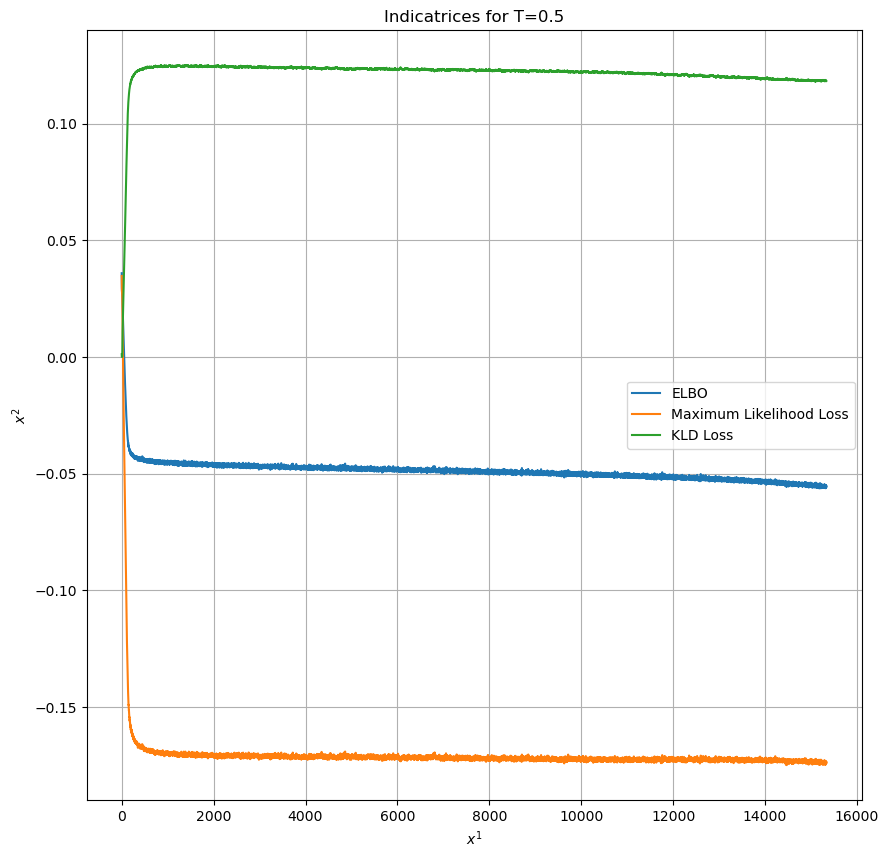

In [103]:
# Plot some training images
recon_batch = model(dataset) #x=z, x_hat, mu, var, kld.mean(), rec_loss.mean(), elbo
x_hat = recon_batch[1].detach()

#Plotting loss function
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(x_hat[:,0], x_hat[:,1], x_hat[:,2], alpha=0.5)
#ax.set_xlabel(r'$x^{1}$')
#ax.set_ylabel(r'$x^{2}$')
#ax.set_zlabel(r'$x^{3}$')
#ax.set_title(r'$\cos^{-1}\frac{\langle s_{\theta}^{t}(x,y,t), \nabla_{y}\ln p(x,y,t) \rangle_{\mathbb{R}^{2}}}{||s_{\theta}^{t}(x,y,t)||_{\mathbb{R}^{2}}\cdot||\nabla_{y}\ln p(x,y,t)||_{\mathbb{R}^{2}}}$')
ax.set_box_aspect([1,1,1])
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_zlabel("$x^{3}$")
ax.set_zlim([0.0,2.0])
ax.set_title("Reconstructed Data")#ax.set_axis_off()
#Plotting loss function
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], alpha=0.5)
#ax.set_xlabel(r'$x^{1}$')
#ax.set_ylabel(r'$x^{2}$')
#ax.set_zlabel(r'$x^{3}$')
#ax.set_title(r'$\cos^{-1}\frac{\langle s_{\theta}^{t}(x,y,t), \nabla_{y}\ln p(x,y,t) \rangle_{\mathbb{R}^{2}}}{||s_{\theta}^{t}(x,y,t)||_{\mathbb{R}^{2}}\cdot||\nabla_{y}\ln p(x,y,t)||_{\mathbb{R}^{2}}}$')
ax.set_box_aspect([1,1,1])
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_zlabel("$x^{3}$")
ax.set_title("Original Data")
#ax.set_axis_off()

#Plotting loss function
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(np.arange(1,epoch+1,1), elbo, label='ELBO')
ax.plot(np.arange(1,epoch+1,1), rec_loss, label='Maximum Likelihood Loss')
ax.plot(np.arange(1,epoch+1,1), kld_loss, label='KLD Loss')
ax.legend()
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Indicatrices for T=0.5")
ax.grid()


## Latent Representation

In [104]:
mu = model.h(dataset)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


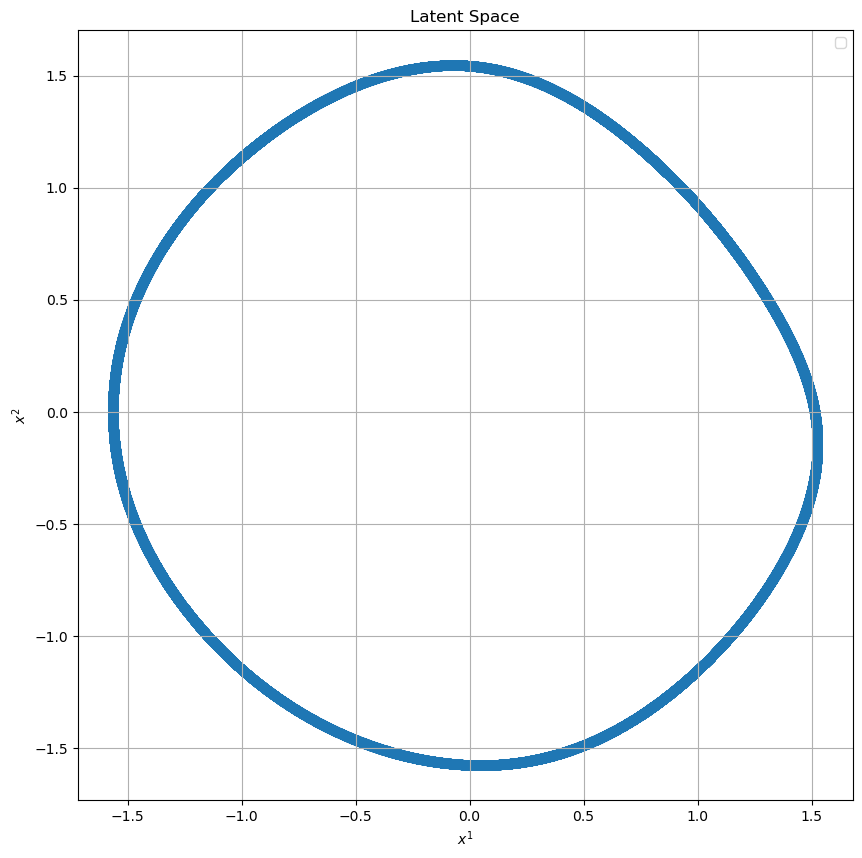

In [105]:
#Plotting loss function
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(mu[:,0].detach().numpy(), mu[:,1].detach().numpy())
ax.legend()
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Latent Space")
ax.grid()

## Computing Geodesics

In [106]:
#Get 3 images to compute geodesics for
gamma_lst = []
gammaz_lst = []
arc_lst = []
T_lst = []

G_plot = torch.empty(1)
for i in range(3):
    x = (dataset[2*i]).view(1, 3).to(device)
    y = (dataset[2*i+1]).view(1, 3).to(device)

    hx = model.h(x).to('cpu')
    hy = model.h(y).to('cpu')

    gamma_linear = M.linear_inter(hx, hy, 100)

    loss, gammaz_geodesic = M.compute_geodesic(gamma_linear,epochs=50000)
    gamma_g_geodesic = model.g(gammaz_geodesic)
    gamma_g_linear = model.g(gamma_linear)

    gammaz_geodesic = gammaz_geodesic.detach()
    gamma_g_linear = gamma_g_linear.detach()

    L_linear = M.arc_length(gamma_g_linear)
    L_geodesic = M.arc_length(gamma_g_geodesic)

    G_plot = torch.cat((gamma_g_linear.detach(), gamma_g_geodesic.detach()), dim = 0)

    arc_length = ['{0:.4f}'.format(L_linear), '{0:.4f}'.format(L_geodesic)]

    gammaz_lst.append(gammaz_geodesic)
    gamma_lst.append(G_plot.to('cpu'))
    arc_lst.append(arc_length)
    T_lst.append(100)

Text(0.5, 0.92, 'Original Data')

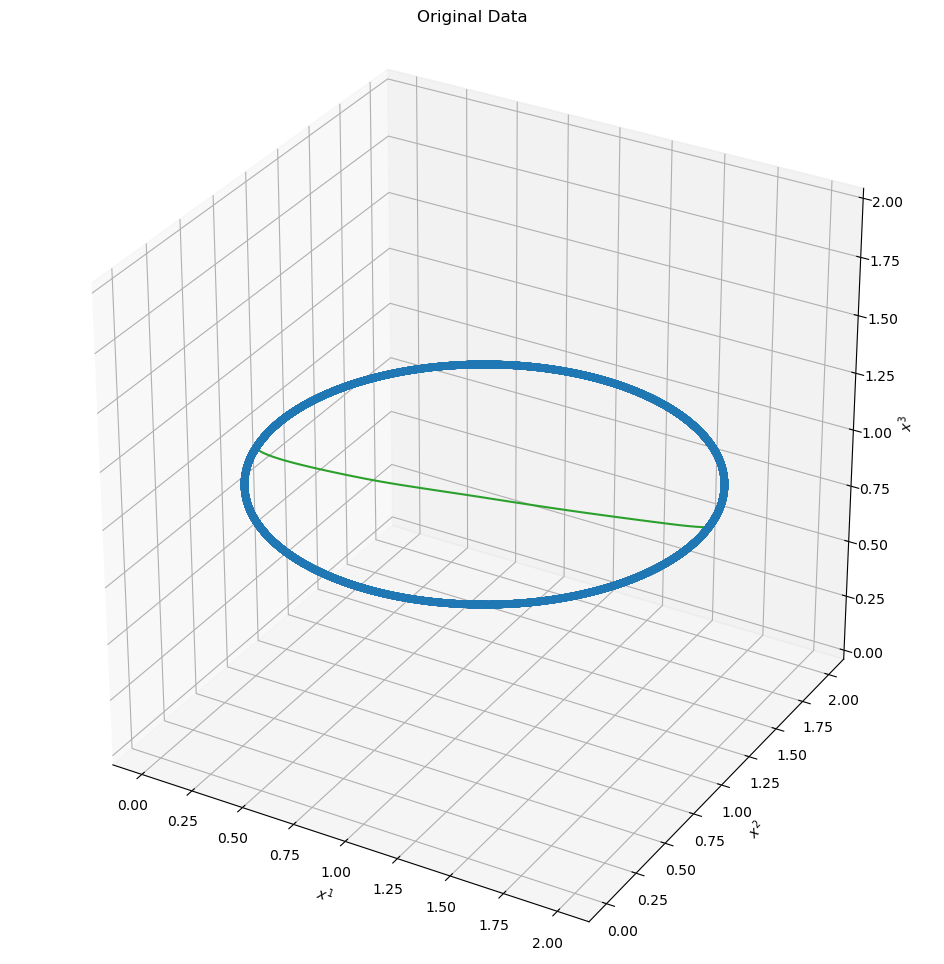

In [107]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], alpha=0.2)
for i in range(3):
    ax.plot(gamma_lst[i][:100,0], gamma_lst[i][:100,1], gamma_lst[i][:100,2])
#ax.set_xlabel(r'$x^{1}$')
#ax.set_ylabel(r'$x^{2}$')
#ax.set_zlabel(r'$x^{3}$')
#ax.set_title(r'$\cos^{-1}\frac{\langle s_{\theta}^{t}(x,y,t), \nabla_{y}\ln p(x,y,t) \rangle_{\mathbb{R}^{2}}}{||s_{\theta}^{t}(x,y,t)||_{\mathbb{R}^{2}}\cdot||\nabla_{y}\ln p(x,y,t)||_{\mathbb{R}^{2}}}$')
ax.set_box_aspect([1,1,1])
ax.set_zlim([0.0,2.0])
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_zlabel("$x^{3}$")
ax.set_title("Original Data")
#ax.set_axis_off()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


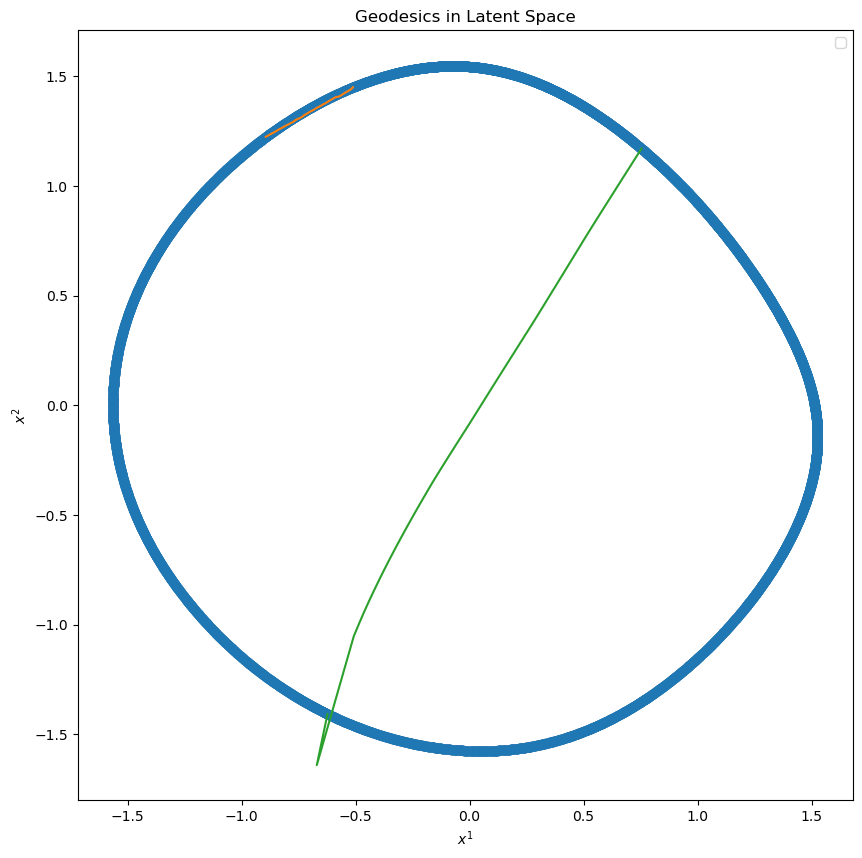

In [108]:
#Plotting loss function
#Plotting loss function
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(mu[:,0].detach().numpy(), mu[:,1].detach().numpy(), alpha=0.1)
ax.legend()
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Latent Space")
ax.grid()
for i in range(len(gammaz_lst)):
    ax.plot(gammaz_lst[i][:,0], gammaz_lst[i][:,1])
ax.legend()
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Geodesics in Latent Space")
ax.grid()

## RELAX 

In [78]:
def MaskGenerator(num_batches, mask_bs, inp_shape=3, num_cells=7, p=0.5, nsd=1, dev='cpu'):
    for batch_i in range(num_batches):

        pad_size = (num_cells // 2, num_cells // 2)
        grid = (torch.rand(mask_bs, 1, *((num_cells,) * nsd), device=dev) < p).float()

        grid_up = F.interpolate(grid, size=(inp_shape), mode='linear', align_corners=False).squeeze()
        #grid_up = F.pad(grid_up, pad_size, mode='reflect')

        shift_x = torch.randint(0, num_cells, (mask_bs,), device='cpu')

        masks = torch.empty((mask_bs, inp_shape), device=dev)

        for i in range(mask_bs):
            masks[i] = grid_up[i]

        yield masks

In [88]:
#@title Implement RELAX

def OnlineRELAX(X, h, Mbar, f_fun, s_fun = nn.CosineSimilarity(dim=1, eps=1e-6),
               R = None, U = None):
    
    with torch.no_grad():
        if R is None:
            R = torch.zeros((1, X.shape[0]), device='cpu')

        if U is None:
            U = torch.zeros((1, X.shape[0]), device='cpu')

        W = torch.zeros_like(R, device='cpu')+1e-8
        for m in Mbar:
            W += m
            hbar = f_fun(X*m)
            s = s_fun(h, hbar)
            R_prev = R
            R += m*(s-R)/W
            U += (s-R)*(s-R_prev )*m

        return R, U/(W-1)


In [89]:
f_fun = model.h
num_masks = 1000
num_batches = 1
j = 0
for batch_i, mask in enumerate(MaskGenerator(num_batches=num_batches, mask_bs=num_masks)):
    R, U = OnlineRELAX(dataset[0], model.h(dataset[0]), mask, f_fun)#.squeeze()
    print(f"Batch {batch_i+1} of masked images.")
    plt.subplot(1,num_batches+2,j+1)
    plt.imshow(R.squeeze())
    plt.subplot(1,num_batches+2,j+2)
    plt.imshow(U.squeeze())
    plt.axis('off')
    j += 1
plt.subplot(1,num_batches+2,j+2)
plt.imshow(real_batch[0][0].squeeze())
plt.axis('off')
plt.tight_layout()
plt.show()

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

Batch 1 of masked images.


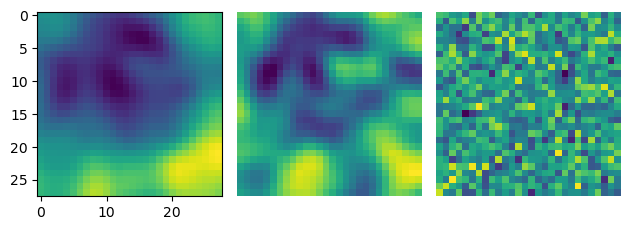

In [67]:
f_fun = model.h
num_masks = 1000
num_batches = 1
j = 0
for batch_i, mask in enumerate(MaskGenerator(num_batches=num_batches, mask_bs=num_masks)):
    R, U = OnlineRELAX(gamma_lst[0][5].view(1,28,28), gammaz_lst[0][5].view(1,2), mask, f_fun)#.squeeze()
    print(f"Batch {batch_i+1} of masked images.")
    plt.subplot(1,num_batches+2,j+1)
    plt.imshow(R.squeeze())
    plt.subplot(1,num_batches+2,j+2)
    plt.imshow(U.squeeze())
    plt.axis('off')
    j += 1
plt.subplot(1,num_batches+2,j+2)
plt.imshow(gamma_lst[0][5].view(1,28,28).squeeze())
plt.axis('off')
plt.tight_layout()
plt.show()

In [68]:
#@title Implement RELAX

def RELAX(X, h, Mbar, f_fun, s_fun = nn.CosineSimilarity(dim=1, eps=1e-6)):
    
    with torch.no_grad():
    #    R = torch.zeros((1, X.shape[2], X.shape[3]), device='cuda')
    #    for m in Mbar:
    #        hbar = f_fun(X*m)
    #        print(s_fun(h, hbar))
    #        R += s_fun(h, hbar)*m

    #    R /= len(Mbar)
    
    #return R
    
        hbar = f_fun(X*Mbar)
        R = s_fun(h, hbar)
    
    return R.mean(axis=0)


In [79]:
f_fun = model.h
num_masks = 1000
num_batches = 1
gamma_relax = []
gamma_dummy = []
for j in range(len(gamma_lst)):
    for k in range(int(len(gamma_lst[j])/2)):
        for batch_i, mask in enumerate(MaskGenerator(num_batches=num_batches, mask_bs=num_masks)):
            gamma_dummy.append(RELAX(gamma_lst[j][k].view(1,28,28), gammaz_lst[j][k].view(1,2), mask, f_fun))#.squeeze()
                               
    gamma_relax.append(torch.stack(gamma_dummy))
    gamma_dummy = []

TypeError: colorbar() missing 1 required positional argument: 'mappable'

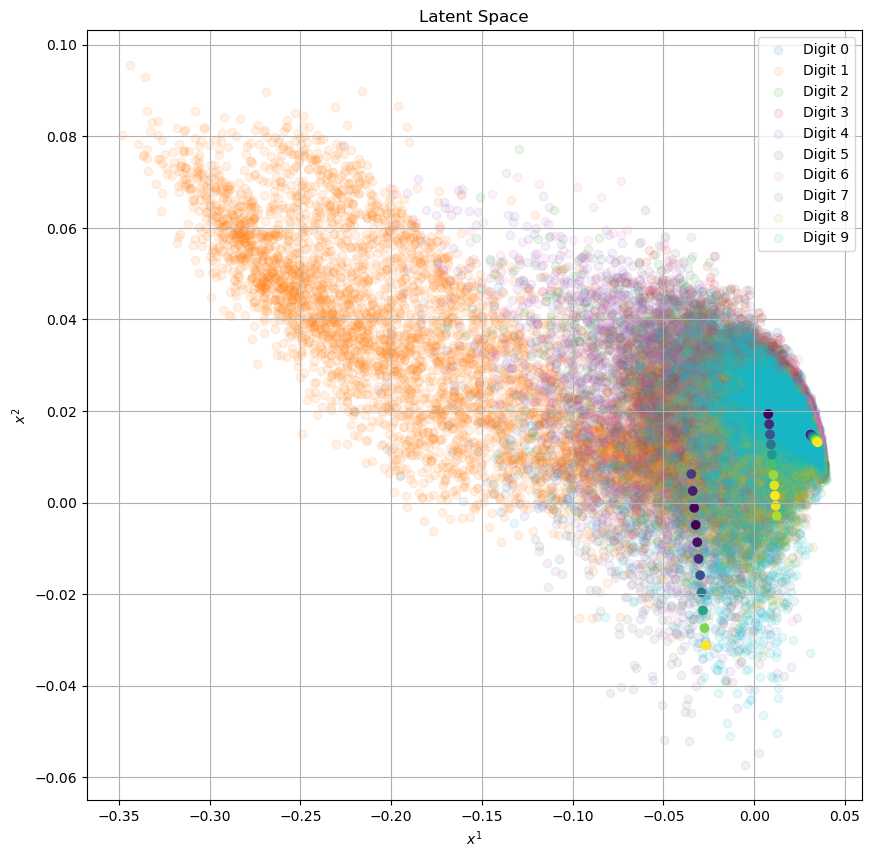

In [87]:
#Plotting loss function
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in np.unique(labels):
    ax.scatter(mu[labels==i,0], mu[labels==i,1], label=' '.join(('Digit', str(i))), alpha=0.1)
ax.legend()
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Latent Space")
ax.grid()
for i in range(len(gammaz_lst)):
    ax.scatter(gammaz_lst[i][:,0], gammaz_lst[i][:,1], c=gamma_relax[i].detach().numpy())
fig.colorbar()
ax.legend()
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Geodesics in Latent Space")
ax.grid()

In [86]:
gamma_relax[1]

tensor([-0.7378, -0.7889, -0.8414, -0.8919, -0.9342, -0.9667, -0.9891, -0.9993,
        -0.9956, -0.9798, -0.9541])